# Conservative 2D wave equation with Neumann boundary control



## 1: Load SCRIMP

In [1]:
import os
# Get the location of the current notebook
path = os.getcwd().split(os.sep)
# Guess the path to SCRIMP (assuming this notebook has not been moved)
rootdir = ""
for dir in path[0:-3]:
    rootdir = rootdir+dir+os.sep
print("Location of root directory for SCRIMP is:", rootdir)
# Append SCRIMP root directory to path
import sys
sys.path.append(rootdir)
# Append all sub-directories to path
import scrimp
scrimp.setup_path(rootdir)


Location of root directory for SCRIMP is: /home/ghaine/Simulations/scrimp_origin/
Appending directories to sys.path using '/home/ghaine/Simulations/scrimp_origin/' as root...
Data directories:
	/home/ghaine/Simulations/scrimp_origin/data
	/home/ghaine/Simulations/scrimp_origin/data/geo_files
2 directories found.
Source directories:
	/home/ghaine/Simulations/scrimp_origin/src/modules
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/tutorials
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/.github
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/multiphenics.egg-info
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/docker
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/tests
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/docs
	/home/ghaine/Simulations/scrimp_origin/src/modules/multiphenics/build
	/home/ghaine/Simulations/scri

## 2: Load other libraries

In [2]:
import numpy as np # Array manipulation
import matplotlib.pyplot as plt # To plot figures
import fenics as fe # Finite elements library
import multiphenics as mpfe # Allow easier use of FEniCS for Mixed Finite Elements Spaces

# Can be found in src/modules directory of SCRIMP
import gmsh_utils
import meshio_utils
import fenics_utils
import multiphenics_utils
 
fe.SubSystemsManager.init_petsc()
from petsc4py import PETSc
import PETSc_utils


## 3: Define geometry from ``.geo`` file and mesh with GMSH

In [3]:
# May be any 2D .geo file in data/geo_file
Geometry = "Rectangle"
# The following parameters are those from .geo files (see data/geo_files directory to adapt them)
L = 1.0
l = 0.5
h = 0.06
params = {'h':h,'hmin':h,'layer':1./2.5,'L':L,'l':l}

# Define string paths
geofile = rootdir+"data/geo_files/"+Geometry+".geo"
gmshfile = rootdir+"data/geo_files/"+Geometry+".msh"

# Dimension must be given explicitly
dim = 2

# Mesh generation
"""
Generate mesh (MSH format, ASCII) from gmsh geometry file.

Parameters
----------
geofile : str
    gmsh geometry file (.geo)
gmshfile : str
    gmsh mesh file (.msh)
dim : int
    Number of spatial dimensions.
order : int, optional
    Geometrical order of mesh. The default is 1.
refinement : int, optional
    Number of refinment steps. The default is 1.
gmshformat : int, optional
    Msh format. The default is 2.
log : int, optional
    Write log to a .log file and print it to standard output. The default is 0.
binary : boolean, optional
    Produce binary mesh (not supported with all format).
parameters: dict, optional
    Parameters values for the .geo file. Format: {'param':val}.

Returns
-------
None.

Remark
------
The ``parameters'' argument is useful to parametrize the geometry described
by the .geo file. In the .geo file, define parameters using
    If (!Exists(param)) param=val_default; EndIf,
so that they can be overriden from Python.

"""
# /!\ : Dolfin (FEniCS) only fully supports first-order meshes
gmsh_utils.generate_mesh_cli(geofile,gmshfile,dim,refinement=1,log=1,\
                             parameters=params,order=1,gmshformat=2,binary=True)
# Print mesh informations
gmsh_utils.print_summary(gmshfile)


Generating mesh '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.msh' from '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.geo'...
Info    : Running '/home/ghaine/anaconda3/envs/scrimp/bin/gmsh -2 /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.geo /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.msh -order 1 -format msh2 -bin -log /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.log -setnumber h 0.06 -setnumber hmin 0.06 -setnumber layer 0.4 -setnumber L 1.0 -setnumber l 0.5' [Gmsh 4.9.2, 1 node, max. 1 thread]
Info    : Started on Fri Jun  3 16:00:13 2022
Info    : Reading '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.geo'...
Info    : Done reading '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.geo'
Info    : Meshing 1D...
Info    : [  0%] Meshing curve 11 (Line)
Info    : [ 30%] Meshing curve 12 (Line)
Info    : [ 50%] Meshing curve 13 (Line)
Info    : [ 80%] Meshing c

## 4: Load XDMF mesh for FEniCS

In [4]:
# Check .msh file
meshio_utils.print_diagnostic_gmsh(gmshfile)
# Convert to XDMF file
xdmfiles = meshio_utils.convert_gmsh_to_XDMF(gmshfile,prune_z=True) # prune_z prunes the third coordinate
# Load in Dolfin format (FEniCS)
dmesh = fenics_utils.DolfinMesh.init_from_xdmf(xdmfiles['tetra'*(dim==3)+'triangle'*(dim==2)],
                                               xdmfiles['triangle'*(dim==3)+'line'*(dim==2)])
# Get the physical tags from .geo file
meshtag = meshio_utils.read_phys_gmsh(xdmfiles['gmsh_physical_entities'])
# Boundaries
bnd_name = "Gamma" # From .geo file, may be a list
Gamma = meshtag[dim-2][bnd_name][0]
# Restriction of the mesh at the boundaries, useful for the space definition
Gamma_restriction = multiphenics_utils.build_MeshRestriction_from_tags(dmesh.mesh,
                                                                       dmesh.boundaries,[Gamma])


---- Mesh /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.msh
773 nodes
2 cell types:
	#0 type: 'line' total: 104
	#1 type: 'triangle' total: 1440
2 physical entities:
	'Gamma' tag: 1 dim: 1
		 104 'line'
	'Omega' tag: 2 dim: 2
		 1440 'triangle'
----
Mesh '/home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle.msh' contains cell types:
	['line', 'triangle']
Exporting nodes and 'line' to /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle_line.xdmf...
Done.
Exporting nodes and 'triangle' to /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle_triangle.xdmf...
Done.
Exporting physical entities name/tag/dim to /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle_phys.json...
Done.
Building dolfin mesh from /home/ghaine/Simulations/scrimp_origin/data/geo_files/Rectangle_triangle.xdmf...
Done. Dolfin mesh properties:
	Dimension: 2
	Order: 1
	Tetra/triangle: 1440
	Nodes: 773
Reading triangle/tetra tags from /home/ghaine/Simulations/

## 5: Finite dimensional spaces

In [5]:
# FE for \alpha_q and e_q
type_q = "RT"
order_q = 2
# FE for \alpha_p and e_p
type_p = "CG"
order_p = 3
# FE for u and y
type_b = "CG"
order_b = 3

# Care must be taken: for Galerkin FE, VectorFunctionSpace must be used instead of FunctionSpace
if ((type_q == 'CG') or (type_q == 'DG')):
    V_q = fe.VectorFunctionSpace(dmesh.mesh, type_q, order_q)
else:
    V_q = fe.FunctionSpace(dmesh.mesh, type_q, order_q)
V_p = fe.FunctionSpace(dmesh.mesh, type_p, order_p)
V_b = fe.FunctionSpace(dmesh.mesh, type_b, order_b)

# Block function space (Mixed Finite Elements)
W = mpfe.BlockFunctionSpace([V_q, V_p, V_b], 
                            restrict=[None, None, Gamma_restriction])

# Test/Trial functions
fun_test = mpfe.block_split(mpfe.BlockTestFunction(W))
fun_trial = mpfe.block_split(mpfe.BlockTrialFunction(W))
                                

## 6: Jacobian

In [6]:
# Young modulus and its inverse (for simplicity)
Txx = "2."
Tyy = "1."
Txy = "0.2 * (1+x[0]) * (1-x[0])"
T = fe.Expression([[Txx,Txy],
                   [Txy,Tyy]], degree=2)
Tinv = fe.Expression([[Tyy,"-"+Txy],
                      ["-"+Txy,Txx]], degree=2)/fe.det(T)

# Mass density
rho = fe.Expression("2. + 0.25 * (1+x[0]) * (1-x[0])", degree=2)

# Admittance boundary damping
admittance = "0.2 * x[0]"
Y = fe.Expression(admittance, element=V_b.ufl_element(), domain=dmesh.mesh)

def Wave_jacobian(fun_trial,fun_test,dx,ds):
    
    # Split trial/test functions
    (e_q, e_p, u_b) = fun_trial
    (v_q, v_p, v_b) = fun_test
    
    # It is not necessary to add null variational formulations, multiphenics handles this
    J_yd = [
                [ -fe.dot(e_q,fe.dot(Tinv,v_q))*dx ], # - M_Tinv d(e_q)/dt = - int_{Omega} d(e_q)/dt . T^{-1} v_q dx
                [ -e_p*rho*v_p*dx ] # - M_rho d(e_p)/dt = - int_{Omega} d(e_p)/dt rho v_p dx
           ]
    
    J_y = [
                [ fe.dot(fe.grad(e_p), v_q)*dx ], # D^T e_p = int_{Omega} grad(e_p) . v_q dx
                [ -fe.dot(e_q, fe.grad(v_p))*dx, u_b*v_p*ds ], # -D^T e_q + B u_b = - int_{Omega} e_q . grad(v_p) dx + int_{Gamma} u_b \gamma_0(v_p) ds
                [ -u_b*v_b*ds, -e_p*Y*v_b*ds ] # - M_b u_b - <Y> y = - int_{Gamma} u_b v_b ds - int_{Gamma} y Y v_b ds
          ]
    
    return (J_yd, J_y)

jacobian = lambda : Wave_jacobian(fun_trial,fun_test,dmesh.dx,dmesh.ds)


## 7: Boundary source term

In [7]:
# UFL Format
t_control_begin = 0.5
t_control_end = 2.5
control = "5. * x[0] * sin(t-"+str(t_control_begin)+") * (t >"+str(t_control_begin)+") * sin("+str(t_control_end)+"-t) * (t < "+str(t_control_end)+")"
u = fe.Expression(control, element=V_b.ufl_element(), domain=dmesh.mesh, t=0.)

def Wave_residual(t,u,fun_test,ds):
    
    u.t = t # u at time t
    
    (v_q, v_p, v_b) = fun_test # Split test functions
    
    return [ [ u*v_b*ds ] ] # M_b u = int_{Gamma} u v_b ds

residual_time_dependent = lambda t : Wave_residual(t,u,fun_test,dmesh.ds)


# 8: Initial data

In [8]:
x0Array = np.zeros(W.dim(),) # Initialisation q0 and p0

q0 = fe.Expression(["0.","0."], element=V_q.ufl_element(), domain=dmesh.mesh)
q0Fun = fe.interpolate(q0, V_q) # Warning: compatible condition "initial data -- boundary control" must be fulfilled
x0Array[0:V_q.dim()] = np.array(q0Fun.vector())

p0 = fe.Expression("0.", element=V_p.ufl_element(), domain=dmesh.mesh)
p0Fun = fe.interpolate(p0, V_p)
x0Array[V_q.dim():V_q.dim()+V_p.dim()] = np.array(p0Fun.vector())

x0 = PETSc.Vec().createWithArray(x0Array)


# 9: Time resolution

In [9]:
# PETSc TS solver options (time integration)
# OptDB collects options for PETSc TS: https://petsc.org/release/docs/manualpages/TS/index.html
# a statement as -option can be passed to PETSc TS by setting OptDB["option"]
OptDB = PETSc_utils.get_cleared_options_db()
PETSc.Sys.pushErrorHandler("python") # To see correctly the errors: interferences between FEniCS and PETSc???

OptDB["ts_type"] = "cn" # Crank-Nicolson
OptDB["ksp_type"] = "preonly" # Direct linear solver
OptDB["pc_type"] = "lu" # LU preconditioner

dt = 0.01
tf = 5.
Integration_params = {'dt_export':5.*dt}

name = "2D Wave equation -- Neumann boundary control"
dae = multiphenics_utils.PDAE_linear(residual_time_dependent,jacobian,
                                     W.dim(),name,idx_alg=[])

PETSc_utils.TS_integration_dae(dae,x0,dt,tf,**Integration_params)

tp = dae.history['t']
zp = dae.history['z']


i=       0 t=       0 * (0s)
i=       1 t=    0.01   (0s)
i=       2 t=    0.02   (0s)
i=       3 t=    0.03   (0s)
i=       4 t=    0.04   (0s)
i=       5 t=    0.05 * (0s)
i=       6 t=    0.06   (0s)
i=       7 t=    0.07   (0s)
i=       8 t=    0.08   (0s)
i=       9 t=    0.09   (0s)
i=      10 t=     0.1 * (0s)
i=      11 t=    0.11   (0s)
i=      12 t=    0.12   (0s)
i=      13 t=    0.13   (0s)
i=      14 t=    0.14   (0s)
i=      15 t=    0.15 * (0s)
i=      16 t=    0.16   (0s)
i=      17 t=    0.17   (0s)
i=      18 t=    0.18   (0s)
i=      19 t=    0.19   (0s)
i=      20 t=     0.2 * (0s)
i=      21 t=    0.21   (0s)
i=      22 t=    0.22   (0s)
i=      23 t=    0.23   (0s)
i=      24 t=    0.24   (0s)
i=      25 t=    0.25 * (0s)
i=      26 t=    0.26   (0s)
i=      27 t=    0.27   (0s)
i=      28 t=    0.28   (0s)
i=      29 t=    0.29   (0s)
i=      30 t=     0.3 * (0s)
i=      31 t=    0.31   (0s)
i=      32 t=    0.32   (0s)
i=      33 t=    0.33   (0s)
i=      34 t= 

i=     277 t=    2.77   (55s)
i=     278 t=    2.78   (55s)
i=     279 t=    2.79   (56s)
i=     280 t=     2.8 * (56s)
i=     281 t=    2.81   (56s)
i=     282 t=    2.82   (56s)
i=     283 t=    2.83   (57s)
i=     284 t=    2.84   (57s)
i=     285 t=    2.85 * (57s)
i=     286 t=    2.86   (57s)
i=     287 t=    2.87   (58s)
i=     288 t=    2.88   (58s)
i=     289 t=    2.89   (58s)
i=     290 t=     2.9 * (58s)
i=     291 t=    2.91   (59s)
i=     292 t=    2.92   (59s)
i=     293 t=    2.93   (59s)
i=     294 t=    2.94   (59s)
i=     295 t=    2.95 * (60s)
i=     296 t=    2.96   (60s)
i=     297 t=    2.97   (60s)
i=     298 t=    2.98   (60s)
i=     299 t=    2.99   (61s)
i=     300 t=       3 * (61s)
i=     301 t=    3.01   (61s)
i=     302 t=    3.02   (62s)
i=     303 t=    3.03   (62s)
i=     304 t=    3.04   (62s)
i=     305 t=    3.05 * (62s)
i=     306 t=    3.06   (63s)
i=     307 t=    3.07   (63s)
i=     308 t=    3.08   (63s)
i=     309 t=    3.09   (63s)
i=     310

# 10: Post-processing

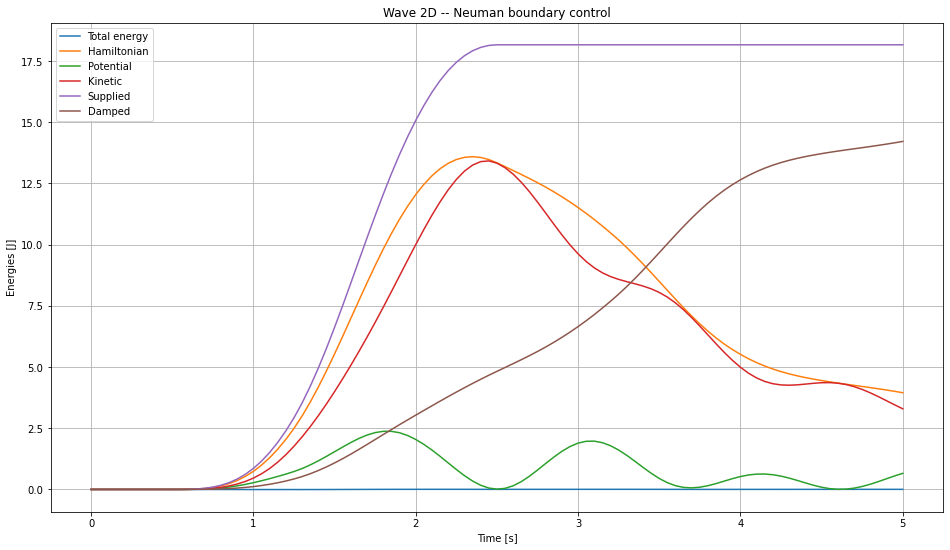

In [10]:
def plot_Hamiltonian(t,z,u,Tinv,rho,Y,fun_trial,fun_test,dx,ds):
    
    # Number of time steps
    Nt = np.array(t).size
    
    # For the potential energy
    Hamq = np.zeros((Nt,))
    
    # For the kinetic energy
    Hamp = np.zeros((Nt,))
    
    # For the total mechanical energy (the Hamiltonian)
    Ham = np.zeros((Nt,))
    
    # For damped energy
    Damped = np.zeros((Nt,))
    
    # For supplied energy
    Supplied = np.zeros((Nt,))
    
    for k in range(1,Nt):
        # Extract solutions
        e_q = mpfe.BlockFunction(W,mpfe.la.BlockPETScVector(z[k]))[0]
        e_p = mpfe.BlockFunction(W,mpfe.la.BlockPETScVector(z[k]))[1]
        e_p_old = mpfe.BlockFunction(W,mpfe.la.BlockPETScVector(z[k-1]))[1]
        # Compute energies
        Hamq[k] = 0.5*fe.assemble(fe.dot(e_q,fe.dot(Tinv, e_q))*dx)
        Hamp[k] = 0.5*fe.assemble(e_p*rho*e_p*dx)
        Ham[k] = Hamq[k] + Hamp[k]
        Damped[k] = Damped[k-1] + 0.5 * (t[k] - t[k-1]) * (fe.assemble(e_p*Y*e_p*ds) + fe.assemble(e_p_old*Y*e_p_old*ds))
        u.t = t[k-1]
        Supplied[k] = Supplied[k-1] + 0.5 * (t[k] - t[k-1]) * fe.assemble(e_p_old*u*ds)
        u.t = t[k]
        Supplied[k] = Supplied[k] + 0.5 * (t[k] - t[k-1]) * fe.assemble(e_p*u*ds)
    
    fig = plt.figure(figsize=(16,9))
    plt.plot(t,Ham+Damped-Supplied,t,Ham,t,Hamq,t,Hamp,t,Supplied,t,Damped)
    plt.title("Wave 2D -- Neuman boundary control")
    plt.xlabel("Time [s]")
    plt.ylabel("Energies [J]")
    plt.grid(axis="both")
    plt.legend(["Total energy","Hamiltonian","Potential","Kinetic","Supplied","Damped"])
    plt.show()

plot_Hamiltonian(tp,zp,u,Tinv,rho,Y,fun_trial,fun_test,dmesh.dx,dmesh.ds)